
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fblaura/FraudD/blob/main/4_Supervised_models/1_Model_training_for_dataset_with_StandardScaler_and_SMOTE0_1.ipynb)

Throughout this notebook you will be working with the original Kaggle competition data, to ensure code execution, it is recommended that you obtain your own personal Kaggle key to download the datasets. You can find more information about the step-by-step for linking Kaggle with Colab at the following link: [Download Kaggle data in Google Colab](https://www.kaggle.com/general/74235)

**Please execute all instructions as indicated.** 


**Some functions and graphs are mentioned in Spanish, please translate them if required.**

# **1. Libraries installation** 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from pandas_profiling import ProfileReport
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Normalizer, StandardScaler

In [36]:
import datetime


In [3]:
from sklearn.preprocessing import LabelEncoder


In [4]:
from google.colab import files

# **2. Information on the subject of the project**


In order to solve a Machine Learning problem that could reflect what was learned during the specialization, a transaction fraud detection competition from the Kaggle site was chosen. 


> This competition provides us with 5 documents (training, test and example of presentation of results for the competition). Between the two training tables that the competition provides us with, there are more than 400 columns and more than 590000 rows of information; due to the volume of data, it is decided to work initially on 1/8 of the original dataset (i.e. 73817 rows). Once we have found relevant information about the models, we will work with all the information in the dataset. Initially, the total amount of data will be explored and analyzed. 

> The link to the competition can be found here: [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/overview) 






# **3. Installation requirements to enable Kaggle**

As explained above, the training dataset is larger than 600 Mb so it is not possible to call the dataset from GitHub (which would have facilitated the execution of the notebook); therefore, this dataset will be called from Kaggle. 

The above can be achieved by enabling an 'API token' from each person's personal Kaggle account (i.e., it is a unique key for each person that is downloaded as a .json file).

**To run this notebook you need to enable your 'API token' in Kaggle, download the 'Kaggle.json' file and upload it in the section below. Without this it is impossible to run the notebook.**.


First, some packages are installed 

In [5]:
! pip install -q kaggle

In the next cell the ***kaggle.json*** (unique file for each Kaggle user) is uploaded.

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lauraaflorez","key":"80fc8a82244c3eba99ea434c6f38a175"}'}

Directories are created in the colab

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

We specify the name of the competition we want to download. The following line of code allows to link the colab with Kaggle downloading all the documents delivered by the competition. 

**NOTE:** Remember to go to your Kaggle profile and accept the terms and conditions of the competition before executing this cell.

In [9]:
! kaggle competitions download -c 'ieee-fraud-detection'

  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 37.2MB/s]
 84% 49.0M/58.3M [00:00<00:00, 90.8MB/s]
100% 58.3M/58.3M [00:00<00:00, 118MB/s] 
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 103MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 101MB/s]
 79% 41.0M/52.2M [00:00<00:00, 56.8MB/s]
100% 52.2M/52.2M [00:00<00:00, 88.8MB/s]


Training files are read: 'train_transaction' and 'train_identity'.

In [10]:
! unzip train_identity.csv.zip 

Archive:  train_identity.csv.zip
  inflating: train_identity.csv      


In [11]:
train_ident = pd.read_csv('train_identity.csv')

In [12]:
! unzip train_transaction.csv.zip 

Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   


In [13]:
train_trans = pd.read_csv('train_transaction.csv')

In [14]:
! unzip test_transaction.csv.zip 

Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    


In [15]:
test_trans = pd.read_csv('test_transaction.csv')

In [16]:
! unzip test_identity.csv.zip 

Archive:  test_identity.csv.zip
  inflating: test_identity.csv       


In [17]:
test_ident = pd.read_csv('test_identity.csv')

In [23]:
test = pd.merge(test_trans, test_ident, on=['TransactionID'],how='left')
train = pd.merge(train_trans, train_ident, on='TransactionID', how='left')


In [19]:
import gc

In [20]:
#del test_trans, test_ident, train_trans, train_ident
gc.collect()

114

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.6+ GB


# **4. Functions**

Due to the volume of the dataset it is necessary to reduce a little the memory of the dataset, converting some types of columns to types that consume less memory: like passing from `float64` to `float16`.

In [25]:
# Memory Reduction
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Uso de memoria disminuyo a {:5.2f} Mb ({:.1f}% de reducción)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

Rename the datasets to save the conversion to smaller memory datasets

In [26]:
train=reduce_mem_usage(train)

Uso de memoria disminuyo a 650.48 Mb (66.8% de reducción)


In [27]:
test=reduce_mem_usage(test)

Uso de memoria disminuyo a 565.37 Mb (66.3% de reducción)


We make use of gc.collect() that collects objects stored in memory, in order to reduce the memory and to be able to work better with the limited conditions that Colab has.

In [28]:
del test_trans, test_ident, train_trans, train_ident
gc.collect()

50

# **5. Data description**

According to the competence, we have the following description of the training dataset columns. At first glance, since it is information related to banking transactions, most of the information is encoded. 
In the future it is necessary to do some Feature Engineering to be able to identify these columns.

**Transaction Table**

*   TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
*   TransactionAMT: transaction payment amount in USD
*   ProductCD: product code, the product for each transaction
*   card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
*   addr: address
*   dist: distance
*   P_ and (R__) emaildomain: purchaser and recipient email domain
*   C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
*   D1-D15: timedelta, such as days between previous transaction, etc.
*   M1-M9: match, such as names on card and address, etc.
*   Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
ProductCD, card1 - card6, addr1, addr2, P_emaildomain, R_emaildomain, M1 - M9

**Identity Table**

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:DeviceType, DeviceInfo, id_12 - id_38

In [29]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


An initial analysis is performed on the columns between the training and test dataset. It can be observed that it seems that the columns are not all the same, so we will work on discovering which characteristics are not congruent. 

In [30]:
print(f'Tamaño de dataset de entrenamiento: {train.shape}')
print(f'Tamaño de dataset de prueba: {test.shape}')
common_cols=set(train.columns).intersection(set(test.columns))
print(f'Número de variables en común, entre ambos datasets: {len(common_cols)}')
print(f'Caracteristicas faltantes: {test.shape[1]-len(common_cols)}')

Tamaño de dataset de entrenamiento: (590540, 434)
Tamaño de dataset de prueba: (506691, 433)
Número de variables en común, entre ambos datasets: 395
Caracteristicas faltantes: 38


It seems that the characteristics that are different are related to the table of identities, which is curious since from the beginning the table of transactions and identities were concatenated for both testing and training. 

In [31]:
missing_cols=list(set(train.columns) - set(test.columns))
missing_cols

['id_11',
 'id_01',
 'id_26',
 'id_08',
 'id_17',
 'id_29',
 'id_10',
 'id_07',
 'id_27',
 'isFraud',
 'id_19',
 'id_05',
 'id_15',
 'id_32',
 'id_21',
 'id_04',
 'id_31',
 'id_14',
 'id_35',
 'id_06',
 'id_28',
 'id_12',
 'id_20',
 'id_23',
 'id_09',
 'id_33',
 'id_34',
 'id_13',
 'id_03',
 'id_38',
 'id_25',
 'id_36',
 'id_16',
 'id_24',
 'id_37',
 'id_30',
 'id_02',
 'id_18',
 'id_22']

It is clear from the next line of code that indeed the test dataset has the identity columns, apparently, the difference lies in the name of the columns. While the training dataset has '_' as the symbol to join the names, the test dataset has a different symbol as '-'. So a replacement of this character will be made. 

In [32]:
test.iloc[:, 393:431].head(5)

,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
train.shape[1]

434

In [34]:
test.columns = test.columns.str.replace("-", "_")

In [35]:
missing_cols=list(set(train.columns) - set(test.columns))
missing_cols

['isFraud']

# **6. Cleaning and Feature Engineering**

## **A. Null values**

Due to the dimensionality of the dataset, an initial cleaning of columns with a large number of null values will be performed. In this case, columns with more than 85% of null values will be eliminated, i.e. columns with 501959 null data out of 590540 total values. 

In [ ]:
null_Values=(train.isnull().sum()/(len(train)))*100
null_Values_but0=null_Values[null_Values > 85]

In [ ]:
columns_to_drop=null_Values_but0.to_frame().T


In [ ]:
columns_to_drop.columns

Index(['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139',
       'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148',
       'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157',
       'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166',
       'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330',
       'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339',
       'id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18',
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30',
       'id_32', 'id_33', 'id_34'],
      dtype='object')

Before proceeding with the elimination, it is decided to make a correlation matrix between the chosen characteristics and the fraud column to see if they are highly correlated. 

In [ ]:
corre_drop=train[columns_to_drop.columns]

In [ ]:
null_corr=pd.concat([corre_drop,train['isFraud']],axis=1) 

In [ ]:
cat_columns = null_corr.select_dtypes(include=['object']).copy() 
le = LabelEncoder()
for feat in cat_columns:
    null_corr[feat] = le.fit_transform(null_corr[feat].astype(str))

print (null_corr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 75 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   dist2    37627 non-null   float16
 1   D6       73187 non-null   float16
 2   D7       38917 non-null   float16
 3   D8       74926 non-null   float16
 4   D9       74926 non-null   float16
 5   D12      64717 non-null   float16
 6   D13      61952 non-null   float16
 7   D14      62187 non-null   float16
 8   V138     81945 non-null   float16
 9   V139     81945 non-null   float16
 10  V140     81945 non-null   float16
 11  V141     81945 non-null   float16
 12  V142     81945 non-null   float16
 13  V143     81951 non-null   float16
 14  V144     81951 non-null   float16
 15  V145     81951 non-null   float16
 16  V146     81945 non-null   float16
 17  V147     81945 non-null   float16
 18  V148     81945 non-null   float16
 19  V149     81945 non-null   float16
 20  V150     81951 non-null   

In [ ]:
# Create correlation matrix
corr_matrix = null_corr.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.35)]

In [ ]:
len(to_drop)

51

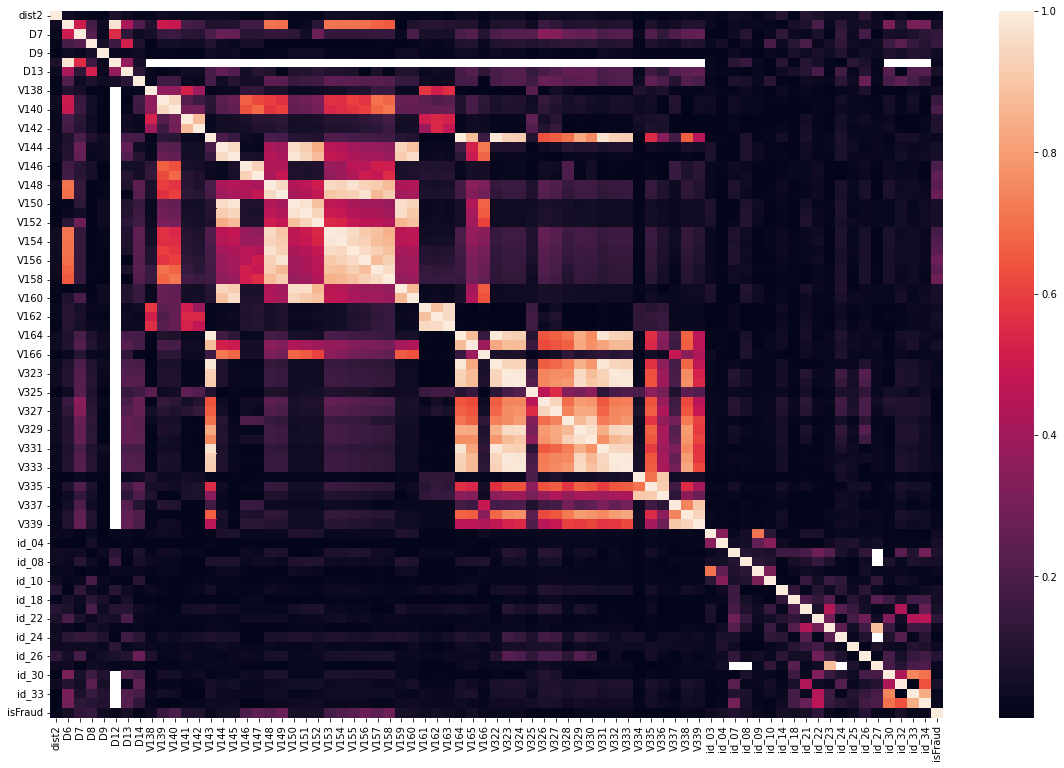

In [ ]:
plt.rcParams["figure.figsize"] = (20,13)
#correlation_mat = null_corr.corr()

sns.heatmap(corr_matrix)

plt.show()

In [ ]:
print('Eliminación de variables con más del 85% de valores nulos')
trainset=train.drop(to_drop, axis=1)
print(f'TRAIN: Tamaño original de características {train.shape[1]} y tamaño resultante {trainset.shape[1]}')
testset=test.drop(to_drop, axis=1)
print(f'TEST: Tamaño original de características {test.shape[1]} y tamaño resultante {testset.shape[1]}')

Eliminación de variables con más del 85% de valores nulos
TRAIN: Tamaño original de características 434 y tamaño resultante 383
TEST: Tamaño original de características 433 y tamaño resultante 382


## **B. Exploration for dataset**

As can be seen in the graph, apart from the dimensionality of the dataset, there is also a large imbalance between the fraud and non-fraud label. Obtaining more than 96% in non-fraud cases, with respect to more than 3% of the cases considered as fraud. 

Text(0, 0.5, 'Porcentaje de casos')

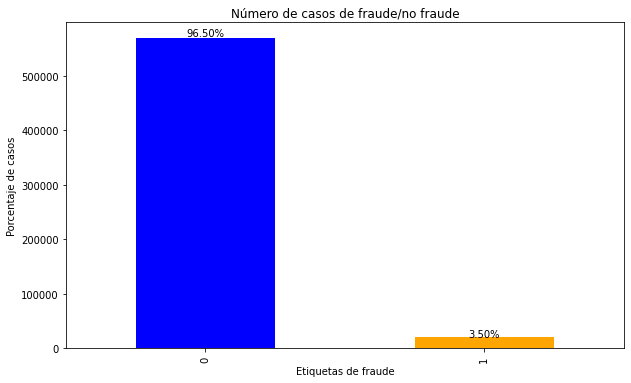

In [ ]:
ax = trainset['isFraud'].value_counts().plot(kind='bar',
                                    figsize=(10,6),
                                    title="Número de casos de fraude/no fraude", color=['blue','orange'])
total=[]
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    total.append(height)
total_val=sum(total)  

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{((height/total_val)):.2%}', (x + width/2, y + height*1.005), ha='center')
ax.set_xlabel("Etiquetas de fraude")
ax.set_ylabel("Porcentaje de casos")

It is also possible to see that the `TransactionDT` column is in fact a column measured in seconds, when converted into days, we can see that for both the training and test datasets a split in time (representing approximately one year of transactions) was performed for the competition. For the training dataset we observe that it contains information for six months, while for the test dataset it is approximately the same amount. Some feature engineering will be done to see if time affects the determination of the fraud category. 

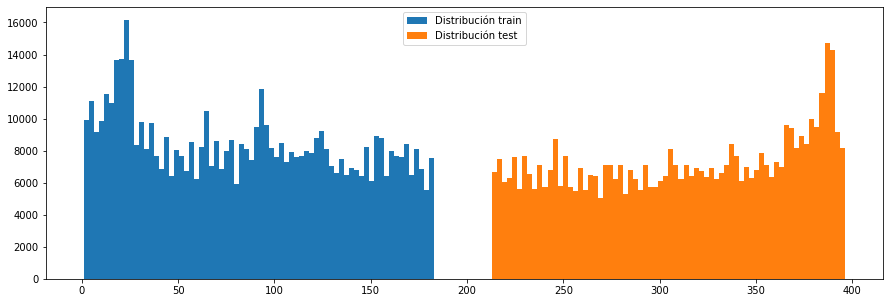

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.hist((trainset['TransactionDT']/86400),bins=70, label='Distribución train')
plt.hist((test['TransactionDT']/86400),bins=70,label='Distribución test')
plt.legend()

In [ ]:
trainset['TransactionDT'].head()

0    86400
1    86401
2    86469
3    86499
4    86506
Name: TransactionDT, dtype: int32

In [ ]:
np.floor(trainset['TransactionDT']/86400).describe()


count    590540.000000
mean         84.729199
std          53.437277
min           1.000000
25%          35.000000
50%          84.000000
75%         130.000000
max         182.000000
Name: TransactionDT, dtype: float64

### **B.1. Email exploring**

In [ ]:
email_fraud=trainset['P_emaildomain'][trainset['isFraud']==1].to_frame()
email_nofraud=trainset['P_emaildomain'][trainset['isFraud']==0].to_frame()

In [ ]:
df=email_fraud.value_counts()
#df.groupby('Team').count()
df

P_emaildomain  
gmail.com          9943
hotmail.com        2396
yahoo.com          2297
anonymous.com       859
aol.com             617
outlook.com         482
comcast.net         246
icloud.com          197
mail.com            106
msn.com              90
live.com             84
outlook.es           57
bellsouth.net        53
ymail.com            50
live.com.mx          41
aim.com              40
protonmail.com       31
att.net              30
cox.net              29
me.com               27
charter.net          25
verizon.net          22
hotmail.es           20
optonline.net        17
yahoo.com.mx         16
mac.com              14
sbcglobal.net        12
gmail                11
earthlink.net        11
embarqmail.com        9
frontier.com          8
juno.com              6
frontiernet.net       5
yahoo.fr              5
suddenlink.net        4
cableone.net          3
roadrunner.com        3
yahoo.es              2
rocketmail.com        2
netzero.net           1
prodigy.net.mx        1


In [ ]:
df2=email_nofraud.value_counts()
df2

P_emaildomain   
gmail.com           218412
yahoo.com            98637
hotmail.com          42854
anonymous.com        36139
aol.com              27672
comcast.net           7642
icloud.com            6070
outlook.com           4614
att.net               4003
msn.com               4002
sbcglobal.net         2958
live.com              2957
verizon.net           2683
ymail.com             2346
bellsouth.net         1856
yahoo.com.mx          1527
me.com                1495
cox.net               1364
optonline.net          994
charter.net            791
live.com.mx            708
rocketmail.com         662
earthlink.net          503
gmail                  485
mail.com               453
mac.com                422
outlook.es             381
juno.com               316
windstream.net         305
roadrunner.com         302
hotmail.fr             295
hotmail.es             285
aim.com                275
frontier.com           272
embarqmail.com         251
web.de                 240
netzero.com

In [ ]:
fraudster=trainset[trainset['isFraud']==1]
fraudster.groupby(by='card4')['ProductCD'].value_counts()



card4             ProductCD
american express  R             111
                  H              91
                  S              35
                  C               2
discover          W             336
                  S              77
                  R              56
                  H              45
mastercard        C            3072
                  W            2438
                  H             413
                  R             373
                  S             200
visa              W            6174
                  C            4916
                  H            1024
                  R             885
                  S             374
Name: ProductCD, dtype: int64

In [ ]:
visas=fraudster[fraudster['card4']=='visa']
visa_card=visas.groupby('P_emaildomain').count()['ProductCD'].to_frame()

In [ ]:
visa_card['P_emaildomain'] = visa_card.index

In [ ]:
visa_card['hours'] = visas.groupby('P_emaildomain').mean()['T_hours'].to_frame()
visa_card['months'] = visas.groupby('P_emaildomain').mean()['T_month'].to_frame()

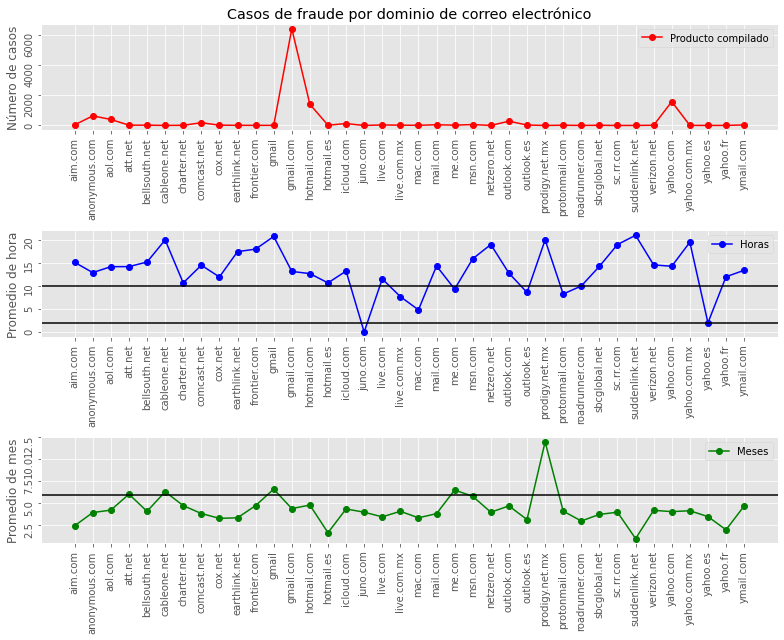

In [ ]:
fig,(ax,ax2,ax3)=plt.subplots(3,1,figsize=(11,9))
ax.plot(visa_card['P_emaildomain'],visa_card['ProductCD'], label='Producto compilado',color='red',marker='o')
ax.tick_params(labelrotation=90)
ax.set_ylabel('Número de casos')
ax.set_title('Casos de fraude por dominio de correo electrónico', color='k')
ax.legend()
ax2.plot(visa_card['P_emaildomain'],visa_card['hours'], label='Horas',color='blue',marker='o')
ax2.set_ylabel('Promedio de hora')
ax2.tick_params(labelrotation=90)
ax2.axhline(y=2, color='k', linestyle='-')
ax2.axhline(y=10, color='k', linestyle='-')
ax2.legend()
ax3.plot(visa_card['P_emaildomain'],visa_card['months'], label='Meses',color='green',marker='o')
ax3.set_ylabel('Promedio de mes')
ax3.axhline(y=6, color='k', linestyle='-')
ax3.tick_params(labelrotation=90)
ax3.legend()
plt.tight_layout()
plt.show()

In [ ]:
visa_card

,ProductCD,P_emaildomain,hours,months
P_emaildomain,,,,
aim.com,39,aim.com,15.128205,2.461538
anonymous.com,637,anonymous.com,12.901099,3.959184
aol.com,398,aol.com,14.185930,4.241206
att.net,20,att.net,14.200000,6.050000
bellsouth.net,20,bellsouth.net,15.200000,4.100000
cableone.net,3,cableone.net,20.000000,6.333333
charter.net,12,charter.net,10.666667,4.750000
comcast.net,182,comcast.net,14.510989,3.851648
cox.net,20,cox.net,11.950000,3.300000


In [ ]:
trainset['T_month'].unique()

array([12,  1,  2,  3,  4,  5,  6])

In [ ]:
np.floor(test['TransactionDT']/86400).describe()


count    506691.000000
mean        311.086427
std          55.058802
min         213.000000
25%         263.000000
50%         314.000000
75%         362.000000
max         395.000000
Name: TransactionDT, dtype: float64

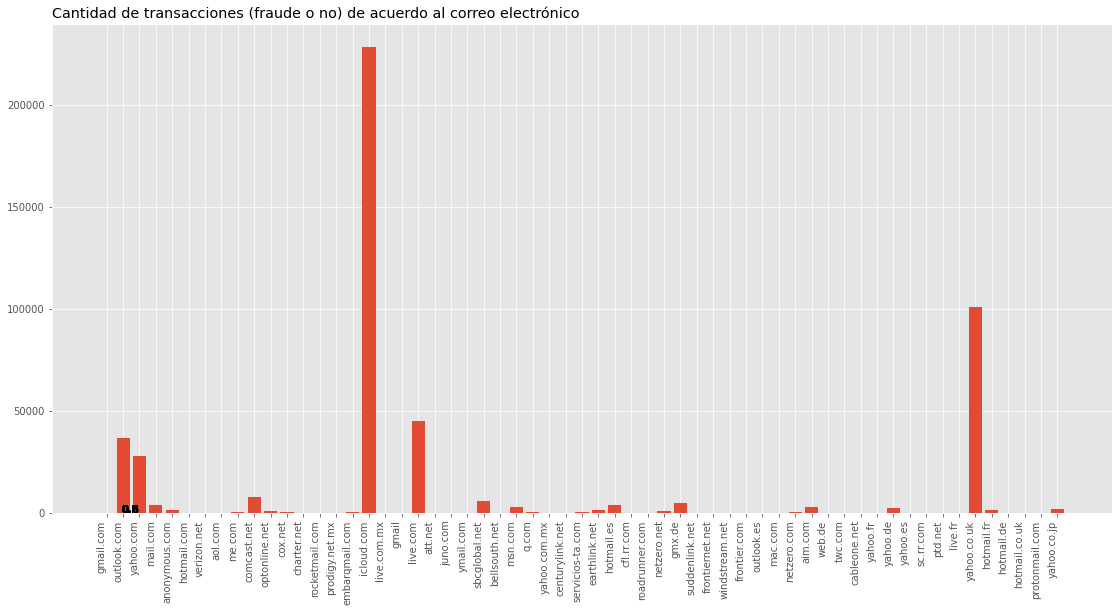

In [ ]:
#Se grafican los cada dominio de correo con respecto a la cantidad de transacciones que presentan
correos=trainset.groupby("P_emaildomain").count()["isFraud"]
etiqueta1=[ 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp']
plot_bar_grouped(etiqueta1,correos,titles='Cantidad de transacciones (fraude o no) de acuerdo al correo electrónico',ancho_plot=19,largo_plot=9,mode='v',rotate_angle=90)

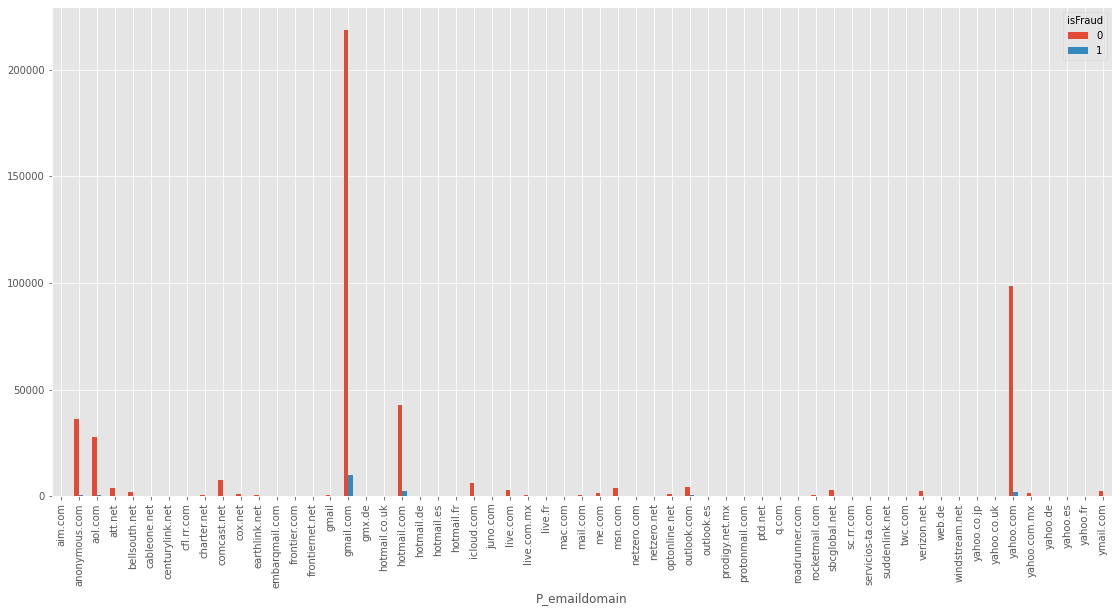

In [ ]:
#Se grafica lo mismo de la línea de código anterior pero se separan las etiquetas
trainset.groupby(['isFraud', 'P_emaildomain'])["P_emaildomain"].count().unstack(level=0).plot(kind='bar',figsize=(19,9))


### **B.2. Card identification**

According to the competition the columns card1,..., card6 represent:
payment card information, such as card type, card category, issuing bank, country, etc.
Looking at the 6 columns one could assume that column card1 (which apparently has 6mil unique values) would refer to the issuer/bank identification number, and was subsequently encoded.



In [ ]:
trainset.groupby('card1')['card1'].count()

card1
1000      1
1001      3
1004      5
1005      1
1006      3
         ..
18390    64
18391     1
18393     3
18395    11
18396     1
Name: card1, Length: 13553, dtype: int64

También, card3 o card5 podría ser el país emisor de la tarjeta.


In [ ]:
regions=trainset[['card3','card5','addr1','addr2','dist1','dist2']]
regions

,card3,card5,addr1,addr2,dist1,dist2
0,150.0,142.0,315.0,87.0,19.0,NaN
1,150.0,102.0,325.0,87.0,NaN,NaN
2,150.0,166.0,330.0,87.0,287.0,NaN
3,150.0,117.0,476.0,87.0,NaN,NaN
4,150.0,102.0,420.0,87.0,NaN,NaN
...,...,...,...,...,...,...
590535,150.0,226.0,272.0,87.0,48.0,NaN
590536,150.0,224.0,204.0,87.0,NaN,NaN
590537,150.0,224.0,231.0,87.0,NaN,NaN
590538,150.0,224.0,387.0,87.0,3.0,NaN


In [ ]:
trainset.groupby(['addr2', 'addr1']).size()

addr2  addr1
10.0   296.0    8
13.0   312.0    1
       430.0    5
       451.0    1
14.0   101.0    1
               ..
101.0  296.0    1
102.0  296.0    5
       323.0    1
       474.0    4
       531.0    1
Length: 437, dtype: int64

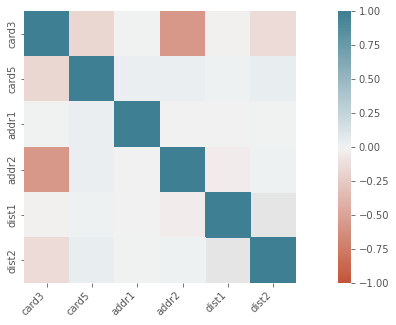

In [ ]:
corr = regions.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

We already know that card4 contains the card type (visa, mastercard, etc.) and card6 contains the card category (credit, debit, etc.).

The other two variables could be:

Individual account identifier.
Some type of card identifier (Card Verification Value (CVV)).
Based on the above, these columns could be concatenated to give rise to a card identifier.

## **C. Development of some features**

### **C.1. Time features**

Due to the fact that the competition took place approximately three years ago, the starting point is considered to be the end of 2017 and the beginning of 2018 (the time in which the competition took place). Characteristics are generated for the time in terms of months and hours.

In [ ]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
trainset['T_DT2'] = trainset['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
testset['T_DT2'] = testset['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
trainset['T_hours']=trainset['T_DT2'].dt.hour
trainset['T_month']=trainset['T_DT2'].dt.month
testset['T_hours']=testset['T_DT2'].dt.hour
testset['T_month']=testset['T_DT2'].dt.month
del trainset['T_DT2'],testset['T_DT2']

We can observe that for the more than 590,000 transactions (distributed over 24 hours) there is an average number of hours for the occurrence of fraud, where the maximum peak occurs between 5 and 10 a.m., which is apparently the time slot where there are fewer transactions. 

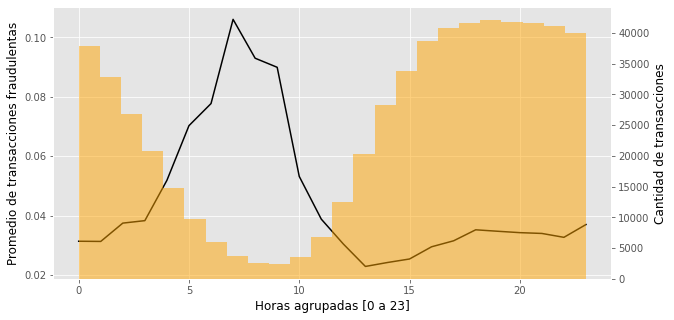

In [ ]:
plt.style.use('ggplot')

fig,ax=plt.subplots(figsize=(10,5))
plt.plot(trainset.groupby('T_hours').mean()['isFraud'], color='k')
ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(trainset['T_hours'], color='orange',alpha=0.5, bins=24)
ax.set_xlabel('Horas agrupadas [0 a 23]',color='k')
ax.set_ylabel('Promedio de transacciones fraudulentas',color='k')

ax2.set_ylabel('Cantidad de transacciones',color='k')
plt.grid(False)

On the other hand, it is observed in the time distribution (in months) of the training dataset that there is a high presence of fraud cases in the sixth month of the year, which also coincides with a low number of transactions for that period of time.

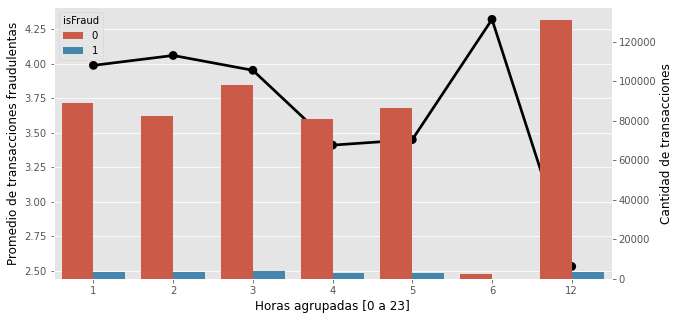

In [ ]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(10,5))
tmp = pd.crosstab(trainset['T_month'], trainset['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
sns.pointplot(x='T_month', y='Fraud', data=tmp, color='black', legend=True, linewidth=0.1)
#plt.plot(trainset.groupby('T_month').mean()['isFraud'], color='k', marker='o')
#ax = plt.gca()
ax2 = ax.twinx()
_ = sns.countplot(x='T_month', data=trainset, hue='isFraud', ax=ax2)
ax.set_xlabel('Horas agrupadas [0 a 23]',color='k')
ax.set_ylabel('Promedio de transacciones fraudulentas',color='k')

ax2.set_ylabel('Cantidad de transacciones',color='k')
plt.grid(False)

In [ ]:
month6=trainset[trainset['T_month'] ==6]

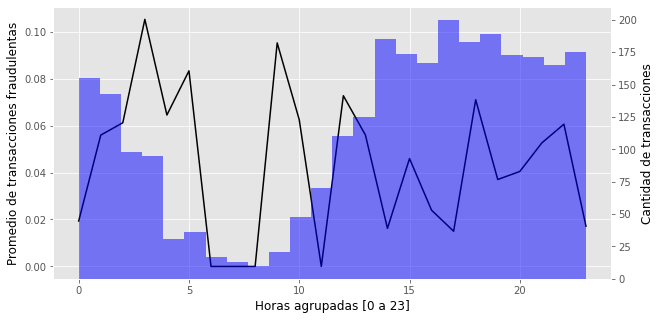

In [ ]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(10,5))
plt.plot(month6.groupby('T_hours').mean()['isFraud'], color='k')
ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(month6['T_hours'], color='blue',alpha=0.5, bins=24)
ax.set_xlabel('Horas agrupadas [0 a 23]',color='k')
ax.set_ylabel('Promedio de transacciones fraudulentas',color='k')

ax2.set_ylabel('Cantidad de transacciones',color='k')
plt.grid(False)

Text(0.5, 0, 'Meses [0 a 6]')

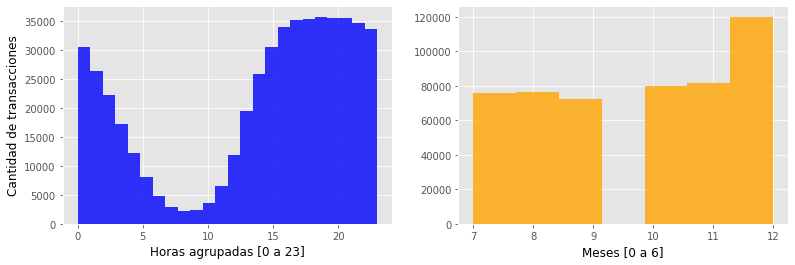

In [ ]:
plt.style.use('ggplot')
fig,(ax,ax2)=plt.subplots(1,2,figsize=(13,4))
ax.hist(testset['T_hours'], color='blue',alpha=0.8, bins=24)
ax.set_xlabel('Horas agrupadas [0 a 23]',color='k')
ax.set_ylabel('Cantidad de transacciones',color='k')
ax2.hist(testset['T_month'], color='orange',alpha=0.8, bins=7)
ax2.set_xlabel('Meses [0 a 6]',color='k')


### **C.2. Transaction digits (currency conversion)**

Another hypothesis that can be handled has to do with the influence of the significant numbers of transactions with the fraud label, relating to the fact that the higher the number of significant numbers would imply transactions coming from foreign places outside the United States. 

In [ ]:
#extraer los centavos
trainset['CurrencyCents']=trainset['TransactionAmt']%1
testset['CurrencyCents']=testset['TransactionAmt']%1

In [ ]:
#extraer la parte entera del precio
trainset['CurrencyDollar']=trainset['TransactionAmt']-trainset['CurrencyCents']
testset['CurrencyDollar']=testset['TransactionAmt']-testset['CurrencyCents']

In [ ]:
#contar para cada transacción cuantas cifras significativas posee
trainset['CentsDigits']= trainset['CurrencyCents'].map(lambda a: len(str(round(a,3)).split(".")[1]))
testset['CentsDigits']= testset['CurrencyCents'].map(lambda a: len(str(round(a,3)).split(".")[1]))


In [ ]:
trainset.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,...,V334,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_28,id_29,id_30,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,T_hours,T_month,CurrencyCents,CurrencyDollar,CentsDigits
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12,0.5,68.0,1
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12,0.0,29.0,1
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12,0.0,59.0,1
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12,0.0,50.0,1
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,12,0.0,50.0,1


In [ ]:
def plot_bar_grouped(label,grouped_df,titles='default',ancho_plot=10,largo_plot=10, mode='h',rotate_angle=0):
  
  if mode=='h':
    fig, ax = plt.subplots(figsize =(ancho_plot, largo_plot))
    #horizontal
    ax.barh(label,grouped_df)
    ax.invert_yaxis()
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.1, i.get_y()+0.4,
                 str(round((i.get_width()), 2)),
                 fontsize = 10, fontweight ='bold',
                 color ='black')
    # Add Plot Title
    ax.set_xticklabels(label, rotation = rotate_angle, ha="right")
    ax.set_title(titles,
                 loc ='left', )    
  elif mode=='v':
    fig, ax = plt.subplots(figsize =(ancho_plot, largo_plot))
    ax.bar(label,grouped_df)
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.1, i.get_y()+0.4,
                 str(round((i.get_width()), 2)),
                 fontsize = 10, fontweight ='bold',
                 color ='black')
    # Add Plot Title
    ax.set_xticklabels(label, rotation = rotate_angle, ha="right")
    ax.set_title(titles,
                 loc ='left', )
  else: 
    print('Sólo modo vertical y horizontal')      


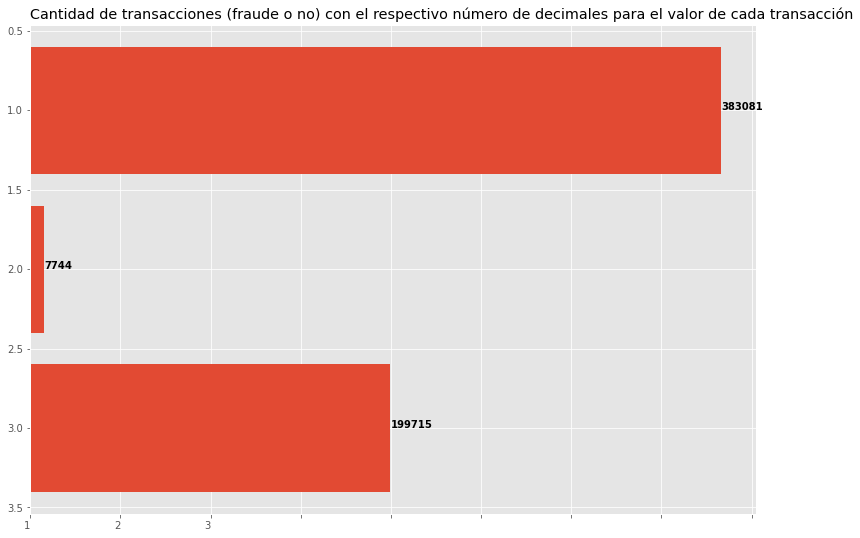

In [ ]:
#distribución de transacciones con respecto al número de cifras significativas
digitos=trainset.groupby("CentsDigits").count()["isFraud"]
labels=[1,2,3]
plot_bar_grouped(labels,digitos,titles='Cantidad de transacciones (fraude o no) con el respectivo número de decimales para el valor de cada transacción',ancho_plot=13,largo_plot=9,mode='h',rotate_angle=0)

It can be observed that there are several cases of fraud with a significant number of 3 digits (possibly a foreign transaction), as well as a large number of fraudulent transactions possibly coming from the same country (USA) due to the number of significant digits. 

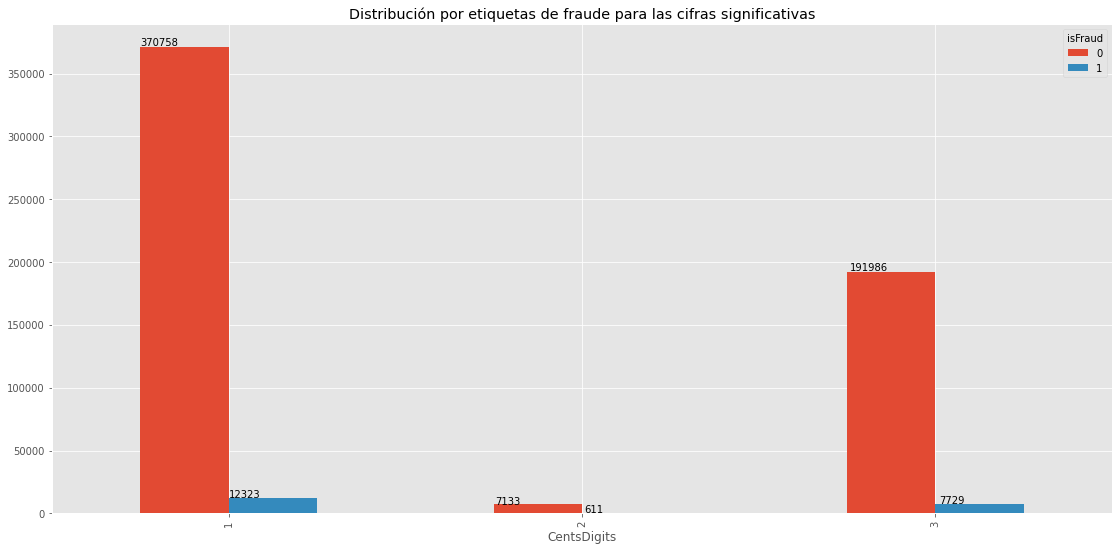

In [ ]:
ax=trainset.groupby(['isFraud', 'CentsDigits'])["CentsDigits"].count().unstack(level=0).plot(kind='bar',figsize=(19,9), title='Distribución por etiquetas de fraude para las cifras significativas')
for p in ax.patches:
  ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

Approximately 34% of transactions with 3 significant figures are labeled as fraud, while 55% of transactions with 1 figure in the value are also labeled as fraud (could be considered as a fraudulent operation performed within the same country, since it did not resort to currency conversion).

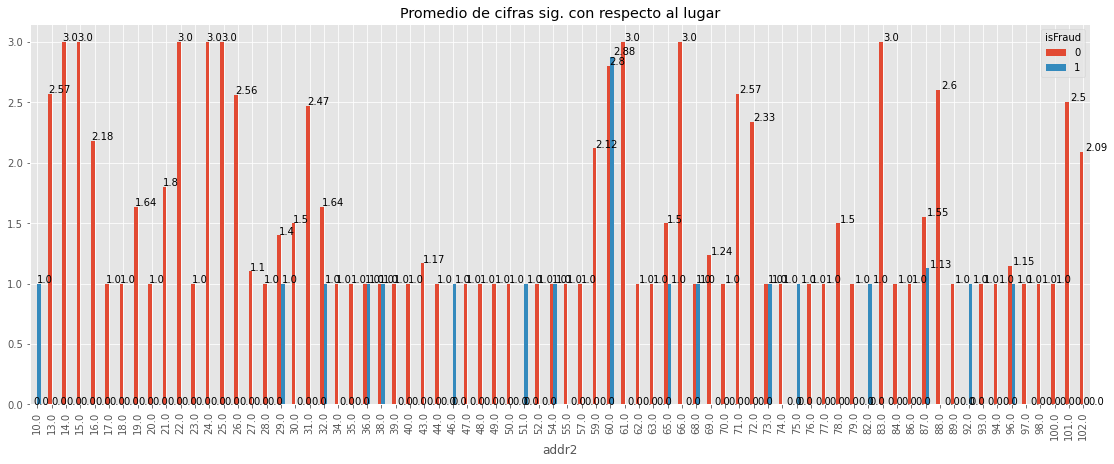

In [ ]:
#de acuerdo a la competencia addr2 podría considerarse como el país de facturación, se hace una comparación entre los países y el número de cifras significativas. 
#Los casos de mayor fraude al parecer se concentran en cuatro regiones
ax=trainset.groupby(["isFraud","addr2"])["CentsDigits"].mean().unstack(level=0).plot(kind='bar',figsize=(19,7),title='Promedio de cifras sig. con respecto al lugar')
for p in ax.patches:
  ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

### **C.3. Transaction Device Verifier**

Another indicator that may denote a case of fraud may be the information provided with respect to the device on which the transaction is made, whether it is a mobile or desktop device. To perform these characteristics, use is made of external information that denotes the different 'user agents' of some devices. 

In [ ]:
trainset[["id_30",	"id_31",	"DeviceType",	"DeviceInfo"]]

,id_30,id_31,DeviceType,DeviceInfo
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,Android 7.0,samsung browser 6.2,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...
590535,NaN,NaN,NaN,NaN
590536,NaN,NaN,NaN,NaN
590537,NaN,NaN,NaN,NaN
590538,NaN,NaN,NaN,NaN


In [ ]:
lista=trainset['DeviceInfo'].unique()
print(lista.shape)

(1787,)


In [ ]:
trainset[trainset['DeviceInfo']=='Windows'].head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,...,V334,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_28,id_29,id_30,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,T_hours,T_month,CurrencyCents,CurrencyDollar,CentsDigits
10,2987010,0,86549,75.875000,C,16496,352.0,117.0,mastercard,134.0,credit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,83.0,0.0,0.0,...,NaN,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,F,F,T,T,desktop,Windows,0,12,0.875000,75.0,3
17,2987017,0,86668,100.000000,H,11492,111.0,150.0,mastercard,219.0,credit,204.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,21.0,0.0,NaN,...,0.0,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,T,F,T,T,desktop,Windows,0,12,0.000000,100.0,1
40,2987040,0,87209,75.875000,C,13329,569.0,117.0,visa,226.0,credit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,2.0,5.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,3.0,2.0,0.0,NaN,NaN,0.0,0.0,0.0,83.0,0.0,0.0,...,NaN,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,F,F,T,T,desktop,Windows,0,12,0.875000,75.0,3
48,2987048,0,87317,42.281250,C,15885,545.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,outlook.com,outlook.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,...,NaN,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,F,F,T,T,desktop,Windows,0,12,0.281250,42.0,3
49,2987049,0,87317,3.595703,C,12730,266.0,185.0,mastercard,224.0,credit,NaN,NaN,NaN,149.0,anonymous.com,anonymous.com,1.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,66.0,66.0,65.0,0.0,NaN,0.0,NaN,NaN,0.0,...,NaN,-5.0,287959.0,NaN,NaN,1.0,-11.0,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,254.0,507.0,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,F,F,T,T,desktop,Windows,0,12,0.595703,3.0,3


In [ ]:
trainset['MobileDevice']= [v if v == 'mobile' else 0 for v in trainset['DeviceType']]
testset['MobileDevice']= [v if v == 'mobile' else 0 for v in testset['DeviceType']]

In [ ]:
trainset['DesktopDevice']= [v if v == 'desktop' else 0 for v in trainset['DeviceType']]
testset['DesktopDevice']= [v if v == 'desktop' else 0 for v in testset['DeviceType']]

In [ ]:
trainset['NoDevice']= [v if pd.isna(v) == True else int(0) for v in trainset['DeviceType']]
testset['NoDevice']= [v if pd.isna(v) == True else int(0) for v in testset['DeviceType']]

In [ ]:
# new data frame with split value columns
particion = trainset["DeviceInfo"].str.split("/", n = 1, expand = True)
  
# making separate first name column from new data frame
trainset["device"]= particion[0]
  
# making separate last name column from new data frame
trainset["serial_device1"]= particion[1]

particion2=trainset["device"].str.split("-", n = 2, expand = True)
trainset["serial_device2"]= particion2[0]
trainset["serial_device3"]= particion2[1]
trainset["serial_device4"]= particion2[2]

In [ ]:
# new data frame with split value columns
particion = testset["DeviceInfo"].str.split("/", n = 1, expand = True)
  
# making separate first name column from new data frame
testset["device"]= particion[0]
  
# making separate last name column from new data frame
testset["serial_device1"]= particion[1]

particion2=testset["device"].str.split("-", n = 2, expand = True)
testset["serial_device2"]= particion2[0]
testset["serial_device3"]= particion2[1]
testset["serial_device4"]= particion2[2]

In [ ]:
particion = trainset["serial_device2"].str.split(" ", n = 1, expand = True)
  
# making separate first name column from new data frame
trainset["serial_device2"]= particion[0]
  
# making separate last name column from new data frame
trainset["serial_device7"]= particion[1]

In [ ]:
particion = testset["serial_device2"].str.split(" ", n = 1, expand = True)
  
# making separate first name column from new data frame
testset["serial_device2"]= particion[0]
  
# making separate last name column from new data frame
testset["serial_device7"]= particion[1]

In [ ]:
# new data frame with split value columns
particion = trainset["serial_device3"].str.split(" ", n = 1, expand = True)
  
# making separate first name column from new data frame
trainset["serial_device3"]= particion[0]
  
# making separate last name column from new data frame
trainset["serial_device6"]= particion[1]

In [ ]:
# new data frame with split value columns
particion = testset["serial_device3"].str.split(" ", n = 1, expand = True)
  
# making separate first name column from new data frame
testset["serial_device3"]= particion[0]
  
# making separate last name column from new data frame
testset["serial_device6"]= particion[1]

In [ ]:
# new data frame with split value columns
particion = trainset["serial_device4"].str.split(" ", n = 1, expand = True)
  
# making separate first name column from new data frame
trainset["serial_device4"]= particion[0]
  
# making separate last name column from new data frame
trainset["serial_device5"]= particion[1]



In [ ]:
# new data frame with split value columns
particion = testset["serial_device4"].str.split(" ", n = 1, expand = True)
  
# making separate first name column from new data frame
testset["serial_device4"]= particion[0]
  
# making separate last name column from new data frame
testset["serial_device5"]= particion[1]

In [ ]:
def brand_device(dataset,columna1,columna2,name_list=' ',search_word=' '):
  str=name_list
  locals()[str] = []
  for ind in dataset.index:
    if columna1[ind]==search_word:
      locals()[str].append(columna2[ind])
    elif columna1[ind]!=search_word:
      locals()[str].append(0)
  return locals()[str]

In [ ]:
trainset['DesktopBrand']=pd.Series(brand_device(trainset,trainset['DeviceType'],trainset['serial_device2'],name_list='desktop_serial',search_word='desktop'))
testset['DesktopBrand']=pd.Series(brand_device(testset,testset['DeviceType'],testset['serial_device2'],name_list='desktop_serial',search_word='desktop'))

In [ ]:
trainset['MobileBrand']=pd.Series(brand_device(trainset,trainset['DeviceType'],trainset['serial_device2'],name_list='mobile_serial',search_word='mobile'))
testset['MobileBrand']=pd.Series(brand_device(testset,testset['DeviceType'],testset['serial_device2'],name_list='mobile_serial',search_word='mobile'))

In [ ]:
def mob_serial_device(dataset,columna1):
  samsung=['SAMSUNG','SPH', 'SCH' ,'SGH','REX']
  generica_americana=['SKY_5.0LM', 'PH','REVVLPLUS','Venue']
  generica_asiatica=['U','F80', 'FTJ152D','Robin','Mobiistar_LAI_Yuna_X','Linux','Le','AX920','AX820','SH','A50C+']
  generica_europea=['FP2','VFD','ZEIA8','Edison','en']   
  cat=[ 'S60']
  verykool=[ 'verykools5035','verykools4009', 'verykools5034','VerykoolS5030','verykoolS5019', 'verykools5004','verykoolS5525','ASUS']
  blu=['Joy','BLU','Studio']
  asus=['ASUS_X00DD','ASUS_Z00AD','ASUS_X015D','ASUS_X008DC','ASUS_Z01BDA','ASUS_Z00UD','ASUS_Z01KD','ASUS_Z00ED']
  motorola=['XT1635','XT1032','MotoG3','XT1254', 'XT1565','XT1585','XT1063','MOT','XT1710','XT1680','XT1092','XT1023','XT1650','XT1064','XT1003','XT1080','XT1058',
            'MotoE2','XT1563','XT1008', 'XT1040','XT1580','XT1053','moto','MotoE2(4G','XT1030','XT1031','XT1055','XT1575','XT1528','XT1021','XT1609','XT1060',
            'V.40R','Turbo','XT1033','XT1096','XT1094','XT1097']
  sony=['LT22i','F3113','D5306','M4', 'E2306','F5121','E5606','F3213', 'E6603', 'E5823','E6633','F5321','D5803','G3313','E5506','G3123', 'E6553','F8331','D6603',
        'E6853','LT30p','F3313','E6833','D6708', 'C2104', 'SGP621','E2104','C6906','D5106','D5316','E2006','G3423','E5803','R1','D6503','G3223','D2306', 'G8141']
  alcatel=['7055A','5012G','5080A','5011A','Alcatel_4060A','5085B', '5010S','5051A','5054N','5025G','8050G', '4027A','5010G','5056A','4047G','4047A','A466BG','Alcatel_5098O',
           '6039A','Alcatel_5044R','6045I','Alcatel_5054O','7048A','4013M','5054S','ALCATEL','5049W','5057M','5095I','A621R','5015A']
  zte=['Z970','Blade','Z836BL','Z981', 'Z839','N817','Z983', 'Z971','K88','Z837VL','Z835','Z798BL','Z982','ZTE','N9136','Z799VL','Z831','Z963VL','Z956','Z959','Z833']
  huawei=['BLL','TRT','ALE','Y635','VKY', 'gxq6580_weg_l','SLA','hi6210sft','BLN','MHA','H1711','CRO','G620S','VTR','KIW', 'H1611','BLA','PRA','MYA','HUAWEI','BAC','CHC','EVA','CAM','WAS']
  lg=['VS500','LGMP260','Nexus','VS988','LGLS676', 'LGLS775','VS995','VS835','LGMS631','EGO','LM','LGLS675','LGL57BL','LGLS991','VS987','VS501','LGMS550','LGL33L','LGMS330',
      'VS820','LGLS751','LGLS770','LGMS210','LGMP450', 'VS996','VS425PP','LGUS215','LGLS990','LGL62VL','VS990','LGMS323','LGL83BL','K92','LGUS990','RS988','VS985', 'LGL84VL',
      'VS986','VS880','VS880PP','LGL58VL','LGLS665', 'LGUS991','LGL52VL','Beat']
  tablet=['RCT6303W87M7', 'KFFOWI','SGP521','VK810','KFASWI', 'KFGIWI','KFAUWI','QTASUN1','KFDOWI','KFSAWI','BNTV400','PLAYTAB','Tab2A7','IdeaTabA1000','TAB7','RCT6203W46', 'VK700','QTAQZ3'
  ,'KFAPWI', 'KFTBWI','NX785QC8G','KFTHWI','QTAIR7','KFTT','QMV7A','KFJWI','1016S','RCT6773W22B','DT0704K08','IdeaTab','K90U','RCT6S03W12','P008','YOGA','RCT6513W87', 'BG2',
  'KFSUWI','LenovoA3300','P027','P00C','KFMEWI','ME173X','NXA116QC164','Coolpad','KFSOWI','ASUS_P00J','S6000','9003A']
  blackberry=[ 'STV100','BBB100','BBA100']
  wiko=['TOMMY2','HIGHWAY']
  honor=['X10','NEM','BND','FRD']
  blackview=['BV6000','Max']
  redmi=[ 'Mi','MI', 'A9','m3']
  kyocera=[ 'C6743','E6810']
  lanix=['Ilium','ILIUM']
  htc=['Hisense', 'HT0701A16','Tornado','2PS64','2PQ93','HTC6545LVW','HTC6500LVW','831C','0PAJ5','2PYB2', '2PZC5','HTC6535LVW','HTC6525LVW','0PJA2','HTC_D10i','0PM92']
  acer=['Z410','S57']
  polaroid=['P4526A','P5526A','P5006A','PSPC550','P5026A']
  lava=['A3_mini','LAVA_A3', 'iris','Grand2c','iris80']
  oppo=['R8106','A37f', 'A96','F1f','A1601']
  one=['ONE','ONEPLUS','A0001']
  nokia=['TA']
  iphone=['iOS','iPhone']
  mobile=[]
  for ind in dataset.index:
    if columna1[ind] in samsung:
      mobile.append('SAMSUNG')
    elif columna1[ind] in generica_americana:
      mobile.append('GENERICA_US')
    elif columna1[ind] in generica_asiatica:
      mobile.append('GENERICA_AS')
    elif columna1[ind] in generica_europea:
      mobile.append('GENERICA_EU')
    elif columna1[ind] in cat:
      mobile.append('CAT')
    elif columna1[ind] in verykool:
      mobile.append('VERYKOOL')
    elif columna1[ind] in blu:
      mobile.append('BLU')
    elif columna1[ind] in asus:
      mobile.append('ASUS')
    elif columna1[ind] in motorola:
      mobile.append('MOTOROLA')
    elif columna1[ind] in sony:
      mobile.append('SONY')
    elif columna1[ind] in alcatel:
      mobile.append('ALCATEL')
    elif columna1[ind] in zte:
      mobile.append('ZTE')
    elif columna1[ind] in huawei:
      mobile.append('HUAWEI')
    elif columna1[ind] in lg:
      mobile.append('LG')
    elif columna1[ind] in blackberry:
      mobile.append('BLACKBERRY')
    elif columna1[ind] in wiko:
      mobile.append('WIKO')
    elif columna1[ind] in honor:
      mobile.append('HONOR')
    elif columna1[ind] in blackview:
      mobile.append('BLACKVIEW')
    elif columna1[ind] in redmi:
      mobile.append('XIAOMI')
    elif columna1[ind] in kyocera:
      mobile.append('KYOCERA')
    elif columna1[ind] in lanix:
      mobile.append('LANIX')
    elif columna1[ind] in htc:
      mobile.append('HTC')
    elif columna1[ind] in acer:
      mobile.append('ACER')
    elif columna1[ind] in polaroid:
      mobile.append('POLAROID')
    elif columna1[ind] in lava:
      mobile.append('LAVA')
    elif columna1[ind] in oppo:
      mobile.append('OPPO')
    elif columna1[ind] in one:
      mobile.append('ONEPLUS')
    elif columna1[ind] in kyocera:
      mobile.append('KYOCERA')
    elif columna1[ind] in nokia:
      mobile.append('NOKIA')
    elif columna1[ind] in iphone:
      mobile.append('IPHONE')
    elif columna1[ind] in tablet:
      mobile.append(0)
    else: 
      mobile.append(columna1[ind])
  return mobile

In [ ]:
trainset['MobileSerial'] = pd.Series(mob_serial_device(trainset,trainset['MobileBrand']))
testset['MobileSerial'] = pd.Series(mob_serial_device(testset,testset['MobileBrand']))
#df_ident.loc[:, 'MobileBrand']

In [ ]:
trainset['MobileSerial2'] = trainset.loc[:, 'MobileSerial']
testset['MobileSerial2'] = testset.loc[:, 'MobileSerial']


In [ ]:
def compare_device(dataset,columna1,columna2):
  comparacion=[]
  for ind in dataset.index:
    if columna1[ind]!= 0 and columna2[ind]!=0:
      if columna1[ind]==columna2[ind]:
        comparacion.append(1)
      else: 
        comparacion.append(-1)
    else:
      comparacion.append(0)
  return comparacion

In [ ]:
trainset['MobileCompareSerial'] = pd.Series(compare_device(trainset,trainset['MobileSerial'],trainset['MobileSerial2']))
testset['MobileCompareSerial'] = pd.Series(compare_device(testset,testset['MobileSerial'],testset['MobileSerial2']))


In [ ]:
trainset.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_28,id_29,id_30,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,T_hours,T_month,CurrencyCents,CurrencyDollar,CentsDigits,MobileDevice,DesktopDevice,NoDevice,device,serial_device1,serial_device2,serial_device3,serial_device4,serial_device7,serial_device6,serial_device5,DesktopBrand,MobileBrand,MobileSerial,MobileSerial2,MobileCompareSerial
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12,0.5,68.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12,0.0,29.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12,0.0,59.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12,0.0,50.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,12,0.0,50.0,1,mobile,0,0.0,SAMSUNG SM-G892A Build,NRD90M,SAMSUNG,G892A,None,SM,Build,None,0,SAMSUNG,SAMSUNG,SAMSUNG,1


In [ ]:
trainset['MobileCompareSerial'].value_counts()


 0    535196
 1     44870
-1     10474
Name: MobileCompareSerial, dtype: int64

In [ ]:
Eliminar=['DeviceInfo',	'MobileDevice',	'DesktopDevice',	'NoDevice',	'device',	'serial_device1',	'serial_device2',	'serial_device3',	'serial_device4',	'serial_device7',	'serial_device6',	'serial_device5',	'DesktopBrand',	'MobileBrand',	'MobileSerial',	'MobileSerial2','id_30',	'id_31','DeviceType'		]
train_df=trainset.drop(Eliminar, axis = 1)
test_df=testset.drop(Eliminar, axis = 1)


# **7. Data imputation**



Due to the presence of so many null values, it is necessary to impute data according to the type of values that make up each column. In this case, the following strategy is used: 


1.   For **real values**, the ***median*** will be used to eliminate null values.
2.   For **integer values**, the ***mean*** will be used to eliminate null values.
3.   For **categorical values**, the ***mode*** will be used to eliminate null values.









In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 385 entries, TransactionID to MobileCompareSerial
dtypes: float16(319), float32(35), int16(1), int32(2), int64(4), int8(1), object(23)
memory usage: 590.5+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 384 entries, TransactionID to MobileCompareSerial
dtypes: float16(312), float32(42), int16(1), int32(2), int64(4), object(23)
memory usage: 515.8+ MB


In [ ]:
dtipos=['float16', 'float32']
floats=train_df.select_dtypes(include=dtipos)
floats=floats.fillna(floats.median())
dtipos=['int16', 'int32', 'int64']
enteros=train_df.select_dtypes(include=dtipos)
enteros=enteros.fillna(enteros.mean())
categoric=train_df.select_dtypes(include='object')
categoric=categoric.fillna(categoric.mode().iloc[0])

In [ ]:
gc.collect()

62

In [ ]:
df_list=[floats,enteros,categoric]
trains=pd.concat(df_list, axis=1)

In [ ]:
trains['isFraud']=train_df['isFraud']

In [ ]:
trains.head(5)

,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D14,D15,V1,V2,V3,V4,V5,V6,...,id_19,id_20,id_21,id_22,id_24,id_25,id_26,CurrencyCents,CurrencyDollar,TransactionID,TransactionDT,card1,T_hours,T_month,CentsDigits,MobileCompareSerial,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_35,id_36,id_37,id_38,isFraud
0,68.5,361.0,150.0,142.0,315.0,87.0,19.0,37.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,341.0,472.0,252.0,14.0,11.0,321.0,149.0,0.5,68.0,2987000,86400,13926,0,12,1,0,W,discover,credit,gmail.com,gmail.com,T,T,T,M2,F,T,F,F,T,NotFound,Found,Found,Found,Found,T,F,T,F,0
1,29.0,404.0,150.0,102.0,325.0,87.0,8.0,37.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,43.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,341.0,472.0,252.0,14.0,11.0,321.0,149.0,0.0,29.0,2987001,86401,2755,0,12,1,0,W,mastercard,credit,gmail.com,gmail.com,T,T,T,M0,T,T,F,F,T,NotFound,Found,Found,Found,Found,T,F,T,F,0
2,59.0,490.0,150.0,166.0,330.0,87.0,287.0,37.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,315.0,0.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,...,341.0,472.0,252.0,14.0,11.0,321.0,149.0,0.0,59.0,2987002,86469,4663,0,12,1,0,W,visa,debit,outlook.com,gmail.com,T,T,T,M0,F,F,F,F,F,NotFound,Found,Found,Found,Found,T,F,T,F,0
3,50.0,567.0,150.0,117.0,476.0,87.0,8.0,37.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,37.875,0.666504,84.0,43.0,0.0,111.0,1.0,1.0,1.0,1.0,1.0,1.0,...,341.0,472.0,252.0,14.0,11.0,321.0,149.0,0.0,50.0,2987003,86499,18132,0,12,1,0,W,mastercard,debit,yahoo.com,gmail.com,T,T,T,M0,T,F,F,F,T,NotFound,Found,Found,Found,Found,T,F,T,F,0
4,50.0,514.0,150.0,102.0,420.0,87.0,8.0,37.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,26.0,10.0,0.0,37.875,0.666504,15.0,43.0,0.0,52.0,1.0,1.0,1.0,1.0,1.0,1.0,...,542.0,144.0,252.0,14.0,11.0,321.0,149.0,0.0,50.0,2987004,86506,4497,0,12,1,1,H,mastercard,credit,gmail.com,gmail.com,T,T,T,M0,F,F,F,F,T,NotFound,New,NotFound,New,NotFound,T,F,T,T,0


In [ ]:
dtipos=['float16', 'float32']
floats=test_df.select_dtypes(include=dtipos)
floats=floats.fillna(floats.median())
dtipos=['int16', 'int32', 'int64']
enteros=test_df.select_dtypes(include=dtipos)
enteros=enteros.fillna(enteros.mean())
categoric=test_df.select_dtypes(include='object')
categoric=categoric.fillna(categoric.mode().iloc[0])

In [ ]:
gc.collect()

50

In [ ]:
df_list=[floats,enteros,categoric]
tests=pd.concat(df_list, axis=1)

In [ ]:
tests.head(5)

,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D14,D15,V1,V2,V3,V4,V5,V6,...,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,CurrencyCents,CurrencyDollar,TransactionID,TransactionDT,card1,T_hours,T_month,CentsDigits,MobileCompareSerial,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_35,id_36,id_37,id_38
0,31.953125,111.0,150.0,226.0,170.0,87.0,1.0,44.0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,0.0,37.71875,0.666504,418.0,203.0,0.0,409.0,1.0,1.0,1.0,1.0,1.0,1.0,...,15.0,321.0,484.0,576.0,14.0,11.0,321.0,147.0,0.953125,31.0,3663549,18403224,10409,0,7,3,0,W,visa,debit,gmail.com,gmail.com,T,T,F,M0,F,F,T,T,T,NotFound,Found,Found,Found,Found,T,F,T,F
1,49.000000,111.0,150.0,226.0,299.0,87.0,4.0,44.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,0.0,37.71875,0.666504,231.0,634.0,0.0,634.0,1.0,1.0,1.0,1.0,1.0,1.0,...,15.0,321.0,484.0,576.0,14.0,11.0,321.0,147.0,0.000000,49.0,3663550,18403263,4272,0,7,1,0,W,visa,debit,aol.com,gmail.com,T,F,F,M0,F,F,F,F,T,NotFound,Found,Found,Found,Found,T,F,T,F
2,171.000000,574.0,150.0,226.0,472.0,87.0,2636.0,44.0,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,0.0,37.71875,0.666504,136.0,136.0,0.0,97.0,1.0,1.0,1.0,1.0,1.0,1.0,...,15.0,321.0,484.0,576.0,14.0,11.0,321.0,147.0,0.000000,171.0,3663551,18403310,4476,0,7,1,0,W,visa,debit,hotmail.com,gmail.com,T,T,F,M0,F,F,F,F,F,NotFound,Found,Found,Found,Found,T,F,T,F
3,285.000000,360.0,150.0,166.0,205.0,87.0,17.0,44.0,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,0.0,37.71875,0.666504,242.0,242.0,0.0,242.0,1.0,1.0,1.0,1.0,1.0,1.0,...,15.0,321.0,484.0,576.0,14.0,11.0,321.0,147.0,0.000000,285.0,3663552,18403310,10989,0,7,1,0,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,T,F,F,T,NotFound,Found,Found,Found,Found,T,F,T,F
4,67.937500,452.0,150.0,117.0,264.0,87.0,6.0,44.0,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,0.0,37.71875,0.666504,22.0,22.0,0.0,22.0,1.0,1.0,1.0,1.0,1.0,1.0,...,15.0,321.0,484.0,576.0,14.0,11.0,321.0,147.0,0.937500,67.0,3663553,18403317,18018,0,7,3,0,W,mastercard,debit,gmail.com,gmail.com,T,T,T,M0,F,F,F,T,T,NotFound,Found,Found,Found,Found,T,F,T,F


Finally, the dataset is saved in pickle format to reduce the size and make it easier to work with. 

In [ ]:
trains.to_csv('trainset.csv',index = False)



In [ ]:
import pickle
with open('trainset.pickle', 'wb') as output:
    pickle.dump(trains, output)

In [ ]:
gc.collect()

302

In [ ]:
tests.to_csv('testset.csv',index = False)


In [ ]:
with open('testset.pickle', 'wb') as output:
    pickle.dump(tests, output)